In [539]:
% reset
% matplotlib inline
import settings
import sympy
from optlang.symbolics import Zero
import cobra.util.solver as sutil
import os, re, cobra, shutil, cobra, time, json, pickle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import libsbml
from libsbml import *
from uncertainties import ufloat
from escher import Builder

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# First we demarcate a system of interest

In [540]:
### read models, core and genome scale (iJO1366) 
GSMM = cobra.io.read_sbml_model(settings.ECOLI_SBML_FNAME)
core = cobra.io.read_sbml_model(settings.ECOLI_CORE_FNAME)

## 1. convert core model to iJO1366 name space, mark descrepancies between models kept

# remove boundary species, don't occur in iJO1366
for rxn in core.reactions:
    for met in rxn.metabolites:
        if met.id.endswith('_b'):
            if rxn.reversibility == False:
                rxn.reaction = re.split(' --> ',rxn.reaction)[0]+' --> '
            else:
                rxn.reaction = re.split(' <=> ',rxn.reaction)[0]+' <=> '
            core.metabolites.remove(met) # does not remove core mets? 
            
# change inconsistence in metabolite naming, adopt iJO1366 standard
manual_rxn_map = {'EX_glc_e':'EX_glc__D_e','EX_gln_L_e':'EX_gln__L_e','EX_glu_L_e':'EX_glu__L_e','EX_lac_D_e':'EX_lac__D_e','EX_mal_L_e':'EX_mal__L_e'}
for met in core.metabolites:
    if met not in GSMM.metabolites:
        met.id = met.id.replace('_','__',1)
for rxn in core.reactions:
    if rxn not in GSMM.reactions:
        if rxn.id in manual_rxn_map:
            rxn.id = manual_rxn_map[rxn.id]
core.repair()


# 2. add additional reactions of interest from iJO1366

# add transport reactions in similar style as the others in the core model
def add_from_iJO1366(rxn_ids_list):
    [core.add_reactions([GSMM.reactions.get_by_id(rxn)]) for rxn in rxn_ids_list]
    return core
### maybe interesting but not added:
# + ['FBA3', 'PFK_3'] + ['MGSA','LGTHL','GLYOX'] + ['OAADC']
# [CITL','FRD2','FRD3','MDH2','MDH3'] + ['F6PA']

## adding pathways for gluconate
GLCNt2r = cobra.Reaction('GLCNt2r') # GLCNt2rpp, GLCNtex
h_e = GSMM.metabolites.get_by_id('h_e')
h_c = GSMM.metabolites.get_by_id('h_c')
glcn_e = GSMM.metabolites.get_by_id('glcn_e')
glcn_c = GSMM.metabolites.get_by_id('glcn_c')
GLCNt2r.add_metabolites({glcn_e: -1.0, h_e:-1.0, glcn_c: 1.0, h_c:1.0})
core.add_reactions([GLCNt2r])
core = add_from_iJO1366(['GNK','EX_glcn_e'])

## adding pathways for glycerol
GLYCt = cobra.Reaction('GLYCt') # GLYCtex, GLYCtpp
glyc_e = GSMM.metabolites.get_by_id('glyc_e')
glyc_c = GSMM.metabolites.get_by_id('glyc_c')
GLYCt.add_metabolites({glyc_e: -1.0, glyc_c: 1.0})
core.add_reactions([GLYCt])
core = add_from_iJO1366(['GLYCDx','DHAPT','G3PD2','G3PT','GLYK','EX_glyc_e'])

## adding pathways for galactose
GALabc = cobra.Reaction('GALabc') # GALtex, GALabspp
gal_e = GSMM.metabolites.get_by_id('gal_e')
gal_c = GSMM.metabolites.get_by_id('gal_c')
atp_c = GSMM.metabolites.get_by_id('atp_c')
adp_c = GSMM.metabolites.get_by_id('adp_c')
h2o_c = GSMM.metabolites.get_by_id('h2o_c')
h_c = GSMM.metabolites.get_by_id('h_c')
pi_c = GSMM.metabolites.get_by_id('pi_c')
GALabc.add_metabolites({gal_e: -1.0, atp_c: -1.0, h2o_c: -1.0, gal_c: 1.0, adp_c: 1.0, pi_c: 1.0, h_c: 1.0})
core.add_reactions([GALabc])

UGLT = cobra.Reaction('UGLT') # effectively removes udpg_c and updgal_c from the original reaction
gal1p_c = GSMM.metabolites.get_by_id('gal1p_c') 
g1p_c = GSMM.metabolites.get_by_id('g1p_c')
UGLT.add_metabolites({gal1p_c: -1.0, g1p_c: 1.0})
core.add_reactions([UGLT])
core = add_from_iJO1366(['PGMT','GALKr','EX_gal_e'])

## changing pathways for pyruvate
core.remove_reactions(['FRUpts2']) # change entry point to fpb_c instead of f6p_c (ambiguous), to match Gerosa 2015
FRUpts = cobra.Reaction('FRUpts')
fru_e = GSMM.metabolites.get_by_id('fru_e')
pep_c = GSMM.metabolites.get_by_id('pep_c')
f1p_c = GSMM.metabolites.get_by_id('f1p_c')
pyr_c = GSMM.metabolites.get_by_id('pyr_c')
FRUpts.add_metabolites({fru_e: -1.0, pep_c: -1.0, f1p_c: 1.0, pyr_c: 1.0})
core.add_reactions([FRUpts])
core = add_from_iJO1366(['FRUK'])

## add ED pathway, ACS for acetate, and MOX for malate oxidase (MQO, MDH2, MDH3: all the same reaction, diff cofactor)
core = add_from_iJO1366(['EDD','EDA'] + ['ACS'] + ['MOX'])

core.reactions.get_by_id('EX_glc__D_e').bounds = [0, 1000] # is not set to zero in the core model initially

core.repair()

cobra.io.write_sbml_model(core, settings.CACHE_DIR+'/extended_core.xml')

# ## biomass equation will be changed later
# for rxn in core.reactions:
#     if not rxn.boundary:
#         print(rxn.id, rxn.check_mass_balance())

# System is demarcated, now we project the Gerosa fluxes

In [541]:
import settings, re
import numpy as np
import pandas as pd

def Physiology(filename):
    short_names = ['growth_rate','uptake','ace_e','lac_e','fum_e','bio_yield']
    df = pd.read_excel(filename, sheet_name= 'Physiology', header=0, index_col=0).dropna(axis=0, how='all')
    df = pd.DataFrame(df.values, index=short_names, columns=df.columns).replace('-','NaN')
    for col in df.columns:
        df.loc[:,col] = df.loc[:,col].str.split(u' ± ')
    s = df.stack().apply(pd.Series)
    mean = s[0].unstack()
    sd = s[1].unstack()
    sd.columns = [x+'_sd' for x in sd.columns]
    df = pd.concat([mean,sd], axis=1)
    return df

def Flux_13C(filename):
    rxn_mapping = {'GLCpts':'GLCpts , EX_glc__D_e',
                   'GlcnUpt':'GLCNt2r , EX_glcn_e',
                   'GALabc':'GALabc , EX_gal_e',
                   'PYRt2r':'PYRt2r , EX_pyr_e',
                   'GlycUpt':'GLYCt , EX_glyc_e',
                   'SUCCt':'SUCCt2_2 , EX_succ_e',
                   'ACS':'ACS , EX_ac_e',
                   'FRUpts':'FRUpts , EX_fru_e',
                   'FUM_SEC':'FUMt2_2 , EX_fum_e',
                   'LDH_D':'LDH_D , EX_lac__D_e',
                   'G3PD5':'G3PD2',
                   'ZWF':'G6PDH2r',
                   'ACONT':'ACONTa',
                   'ACONT2':'ACONTb',
                   'SUCDH3':'SUCDi',
                   'MQO':'MOX',
                   'Growth_rate':'Biomass_Ecoli_core_w_GAM',
                   }

    df = pd.read_excel(filename, sheet_name= 'Metabolic fluxes', header=0, index_col=0).dropna(axis=1, how='all')
    columns = list(df.values[:1][0,0:8]) + list([x+'_sd' for x in df.values[:1][0,0:8]])
    flux_rxns = list(df.iloc[0:-2,19].values) + [df.index[-1]]
    index = pd.Series([' '.join([rxn_mapping[rxn] if rxn in rxn_mapping else rxn for rxn in re.findall(r'\b\w+\b|\+|\-|\(|\)|,', rxns)]) for rxns in flux_rxns], index=df.index[1:])
    return pd.DataFrame(list(df.values[1:][0:,0:16]) , columns=columns, index=index)

def Expand_flux_13C(flux_13C):
    
    ### fix coa_c / accoa_c / ac_c balance
    b_c = 3.7478
    COA = - flux_13C.loc['( ACt2r , ACKr , PTAr ) + ACS , EX_ac_e',:] \
        + flux_13C.loc['( ICL , MALS )',:] \
        + flux_13C.loc['( CS , ACONTa , ACONTb )',:] - flux_13C.loc['( PDH )',:]\
        + b_c * flux_13C.loc['Biomass_Ecoli_core_w_GAM',:] 
    flux_13C.loc['( ACt2r , ACKr , PTAr ) + ACS , EX_ac_e',:] = flux_13C.loc['( ACt2r , ACKr , PTAr ) + ACS , EX_ac_e',:].add(COA[0:8])

    vector_index = [item for sublist in [re.findall(r'\b\w+\b', flux) for flux in flux_13C.index] for item in sublist]
    df = pd.DataFrame(index=vector_index, columns=flux_13C.columns)
    for flux in flux_13C.index:
        rxns = re.findall(r'\b\w+\b', flux)
        signs = [np.sign(x) > 0 for x in flux_13C.loc[flux,:]][:8]*2 # mean sign determines assignment of sd to rxns
        
        ### futile cycles
        if flux == '( PYK - PPS )' or flux == '( PFK - FBP )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]  * signs
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:] * [not i for i in signs]
        
        ### isoenzymes (parallel reactions)
        elif flux == '( MDH + MOX )' or flux == '( ME1 + ME2 )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:] * signs
            df.loc[rxns[1],:] = [0]*16
            
        ### rest from here is uptake systems
        elif flux == '( GLCpts , EX_glc__D_e )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
        elif flux == '( GLCNt2r , EX_glcn_e , GNK )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
            df.loc[rxns[2],:] = flux_13C.loc[flux,:]
        elif flux == '( GALabc , EX_gal_e , GALKr , UGLT , PGMT )': 
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
            df.loc[rxns[2],:] = flux_13C.loc[flux,:]
            df.loc[rxns[3],:] = flux_13C.loc[flux,:]
            df.loc[rxns[4],:] = flux_13C.loc[flux,:]
        elif flux == '( PYRt2r , EX_pyr_e )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
        elif flux == '( GLYCt , EX_glyc_e , GLYK , G3PD2 )': 
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]  *2
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:] *2
            df.loc[rxns[2],:] = flux_13C.loc[flux,:]  *2
            df.loc[rxns[3],:] = flux_13C.loc[flux,:]  *2
        elif flux == '( SUCCt2_2 , EX_succ_e )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
        elif flux == '( ACt2r , ACKr , PTAr ) + ACS , EX_ac_e':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = flux_13C.loc[flux,:]  * [not i for i in signs]
            df.loc[rxns[2],:] = -flux_13C.loc[flux,:] * [not i for i in signs]
            df.loc[rxns[3],:] = flux_13C.loc[flux,:]  * signs
            df.loc[rxns[4],:] = -flux_13C.loc[flux,:]
        elif flux == '( FRUpts , EX_fru_e , FRUK )': 
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
            df.loc[rxns[2],:] = flux_13C.loc[flux,:]
        elif flux == '( LDH_D , EX_lac__D_e , D_LACt2 )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
            df.loc[rxns[2],:] = flux_13C.loc[flux,:]
        elif flux == '( FUMt2_2 , EX_fum_e )':
            df.loc[rxns[0],:] = flux_13C.loc[flux,:]
            df.loc[rxns[1],:] = -flux_13C.loc[flux,:]
        
        ### set the rest of the intracellular reactions
        else:
            for rxn in rxns: 
                df.loc[rxn,:] = flux_13C.loc[flux,:]
    
    ### fix akg_c balance
    b_c = 4.1182
    GLUSy = df.loc['ICDHyr',:] - df.loc['AKGDH',:] + b_c * df.loc['Biomass_Ecoli_core_w_GAM',:]
    df = df.append(pd.DataFrame(np.append(np.array(GLUSy[0:8]), (np.zeros(8))), index = df.columns, columns=['GLUSy']).T, )
    df = df.append(pd.DataFrame(np.append(np.array(GLUSy[0:8]), (np.zeros(8))), index = df.columns, columns=['GLNS']).T, )

    ### flip signs for reactions that are reversed
    for r in df.index:
        if r in ['PGM','PGK','RPI','SUCOAS']:
            df.loc[r, :] = -df.loc[r, :]

    return df

## input files (supplementary files Gerosa, 2015)
ss_data = settings.DATA_DIR+'/Gerosa_2015_S2.xlsx'

## physiological data split into mean and sd
physiology = Physiology(ss_data)
# physiology.to_csv(settings.CACHE_DIR+'/gerosa_physiology.csv')

## map the fluxes to their corresponding rxns to BiGG reactions
flux_13C = Flux_13C(ss_data)
# flux_13C.to_csv(settings.CACHE_DIR+'/gerosa_fluxes_to_BiGG.csv')

## assign the flux to corresponding reactions, fix errors, and match the directionality in the gerosa model
rxns_13C = Expand_flux_13C(flux_13C)
# rxns_13C.to_csv(settings.CACHE_DIR+'/gerosa_fluxes_per_rxn.csv')
# model.reactions.get_by_id('FUMt2r')




In [559]:
# core = cobra.io.read_sbml_model(settings.CACHE_DIR+'/extended_core.xml')
# ss_data = settings.DATA_DIR+'/Gerosa_2015_S2.xlsx'
# flux_solution = dict()
# rxns_13C = pd.read_csv(settings.ECOLI_GEROSA_FLUX, index_col=0)
rxns_13C = Expand_flux_13C(flux_13C)

for cond in ['Acetate','Glycerol','Galactose']:
    rxns_13C.loc['ACKr',cond] = -rxns_13C.loc['ACKr',cond]
    

# for cond in ['Glucose','Gluconate','Pyruvate','Succinate','Fructose']:
#     rxns_13C.loc['ACKr',cond] = -rxns_13C.loc['ACKr',cond]

for cond in ['Pyruvate']:
    rxns_13C.loc['LDH_D',cond] = -rxns_13C.loc['LDH_D',cond]
    rxns_13C.loc['EX_lac__D_e',cond] = -rxns_13C.loc['EX_lac__D_e',cond]
    rxns_13C.loc['D_LACt2',cond] = -rxns_13C.loc['D_LACt2',cond]

for cond in ['Acetate']: 
#     rxns_13C.loc['ACKr',cond] = -rxns_13C.loc['ACKr',cond]
    rxns_13C.loc['PTAr',cond] = -rxns_13C.loc['PTAr',cond]
    rxns_13C.loc['ACS',cond] = -rxns_13C.loc['ACS',cond]
    
for cond in ['Acetate']: # flipping: ( ACKr , PTAr ) + ACS
    rxns_13C.loc['ACKr',cond] = -rxns_13C.loc['ACS',cond]
    rxns_13C.loc['ACS',cond]  = rxns_13C.loc['PTAr',cond]
    rxns_13C.loc['PTAr',cond] = -rxns_13C.loc['ACKr',cond]    

for cond in ['Gluconate']:
    pass
for cond in ['Succinate']:
    rxns_13C.loc['SUCCt2_2',cond] = rxns_13C.loc['SUCCt2_2',cond]
    rxns_13C.loc['EX_succ_e',cond] = rxns_13C.loc['EX_succ_e',cond] + 2.25 ## artifial without excuse
#         elif flux == '( SUCCt2_2 , EX_succ_e )':
#             df.loc[rxns[0],:] = flux_13C.loc[flux,:]
#             df.loc[rxns[1],:] = -flux_13C.loc[flux,:]


# succinate: EX_succ_e, FUMt2_2, EX_fum_e    
# acetate : ACKr, PTAr, ACS

In [560]:
class BiomassComposition(object):
    
    def __init__(self, organism='e_coli_fixed'):
        self.organism = organism
        
        if self.organism is not None:
            self.precursor_df = pd.read_excel(settings.DATA_DIR+'/meta_analysis.xls',
                                              sheet_name=self.organism + "_biomass",
                                              index_col=0, header=0).fillna(0)
            
            # a Series containing the growth dependence function for each sector
            self.growth_dependence = self.precursor_df['growth dependence'].apply(
                    lambda s: sympy.sympify(s))
            
            # a DataFrame with the required amount of each precursor in mmol
            # per 1 gram of that sector
            self.precursor_df = self.precursor_df.iloc[:, 1:]
    
    def GetSectorCorrections(self, growth_rate):
        """
            Returns a dataframe with the sector correction factors, which are
            the only growth-rate dependent part
        """
        mu = sympy.symbols('mu')
        
        if type(growth_rate) == float:
            growth_rate = ufloat(growth_rate, 0)
        
        sectors = {}
        for sect, func in self.growth_dependence.items():
            factor = func.evalf(subs={mu:growth_rate.nominal_value})
            uncert = np.abs(sympy.diff(func).evalf(subs={mu:growth_rate})) \
                * growth_rate.std_dev
            sectors[sect] = ufloat(factor, uncert)
        
        return pd.Series(sectors)
    
    def GetComposition(self, growth_rate, uncertainty=0.0):
        """
            Returns a Series containing values of each precursor in the biomass
            in units of mmol per gram of cell dry weight
        """
        if self.organism is None:
            return pd.Series()
        else:
            sector_correction_factors = self.GetSectorCorrections(growth_rate)
            biomass_df = self.precursor_df.transpose().multiply(sector_correction_factors)
            return biomass_df.transpose().apply(np.sum)

        
def adjust_biomass(model, new_biomass):
    
    mets = []
    mapping = {'ATP':'atp_c = adp_c + pi_c',
               'G6P':'g6p_c',
               'PEP':'pep_c',
               'PYR':'pyr_c',
               'F6P':'g6p_c',
               'T3P':'dhap_c',
               'PGA':'3pg_c',
               'NADH':'nadh_c = nad_c',
               'NADPH':'nadph_c = nadp_c',
               'CO2':'co2_c',
               'R5P':'r5p_c',
               'E4P':'e4p_c',
               'OAA':'oaa_c',
               'AcCoA':'accoa_c = coa_c',
               'OGA':'akg_c'}
    
    for k,v in new_biomass.to_dict().items():
        if k == 'ATP': # 'ATP':'atp_c = adp_c + pi_c',
            mets += [('atp_c', v.nominal_value * -1)]
            mets += [('adp_c', v.nominal_value)]
            mets += [('pi_c', v.nominal_value)]
        elif k == 'NADH':
            mets += [('nadh_c', v.nominal_value * -1)]
            mets += [('nad_c', v.nominal_value)]
        elif k == 'NADPH':
            mets += [('nadph_c', v.nominal_value * -1)]
            mets += [('nadp_c', v.nominal_value)]
        elif k == 'AcCoA':
            mets += [('accoa_c', v.nominal_value * -1)]
            mets += [('coa_c', v.nominal_value)]    
        else:   
            mets += [(mapping[k], v.nominal_value * -1)]
        
    ### remove the old, replace by new
    model.remove_reactions(['Biomass_Ecoli_core_w_GAM'])
    Biomass_Ecoli_core_w_GAM = cobra.Reaction('Biomass_Ecoli_core_w_GAM') 
    d = {GSMM.metabolites.get_by_id(met[0]): met[1] for met in mets}
    Biomass_Ecoli_core_w_GAM.add_metabolites(d)
    model.add_reactions([Biomass_Ecoli_core_w_GAM])
    model.objective = 'Biomass_Ecoli_core_w_GAM'
    
    return model
        

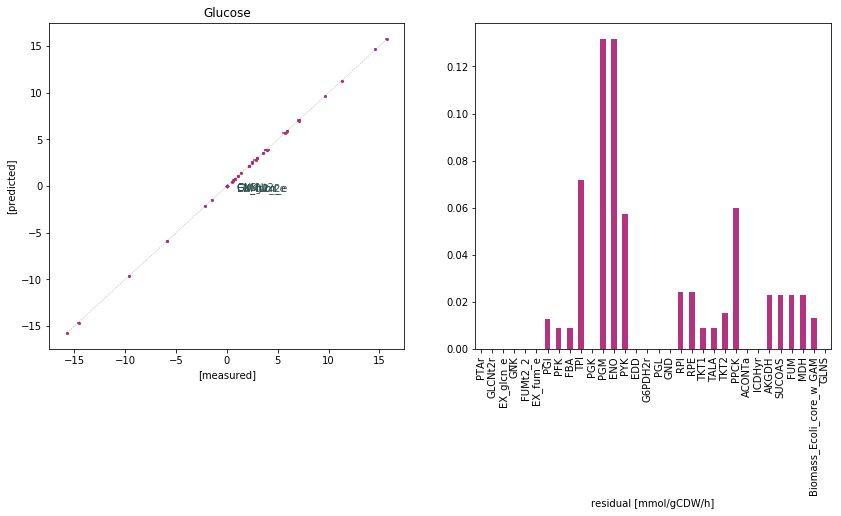

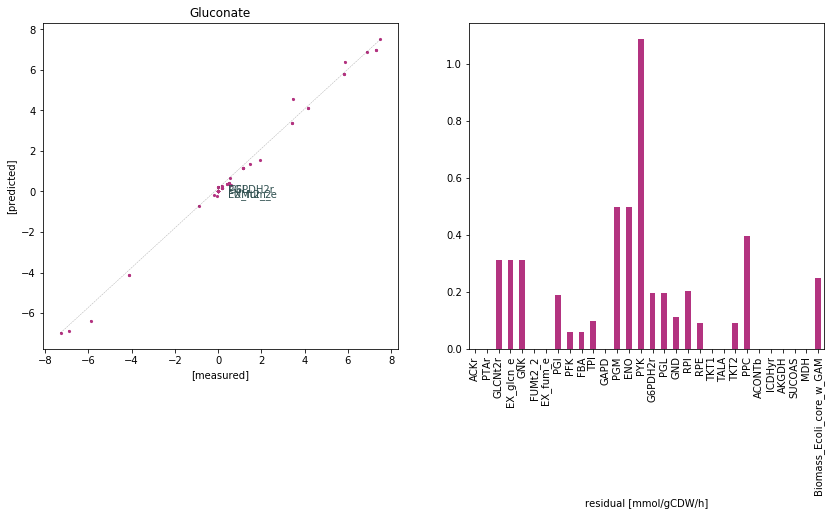

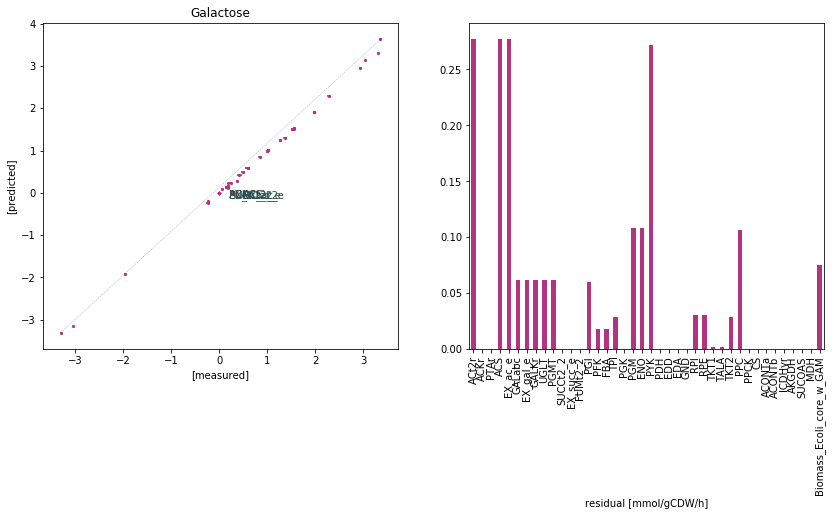

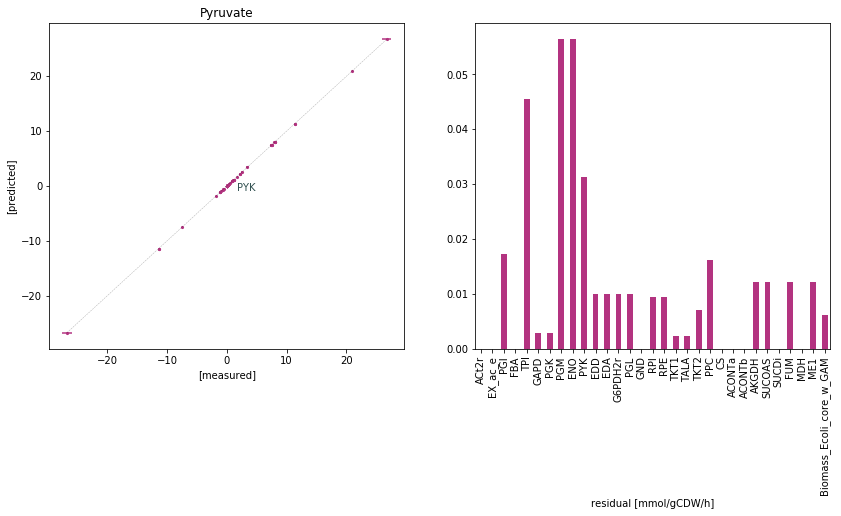

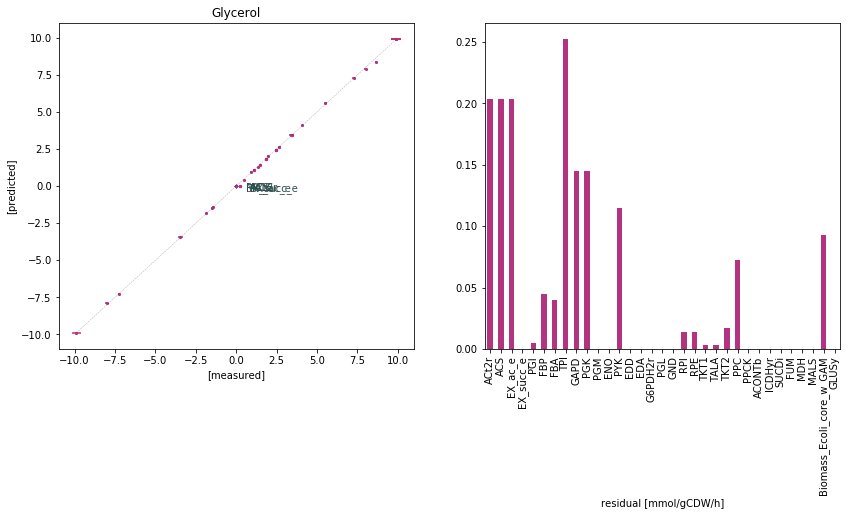

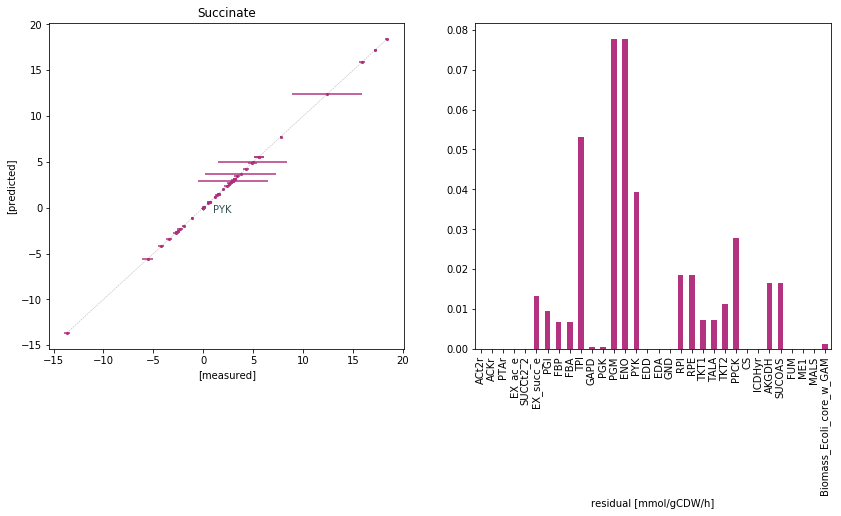

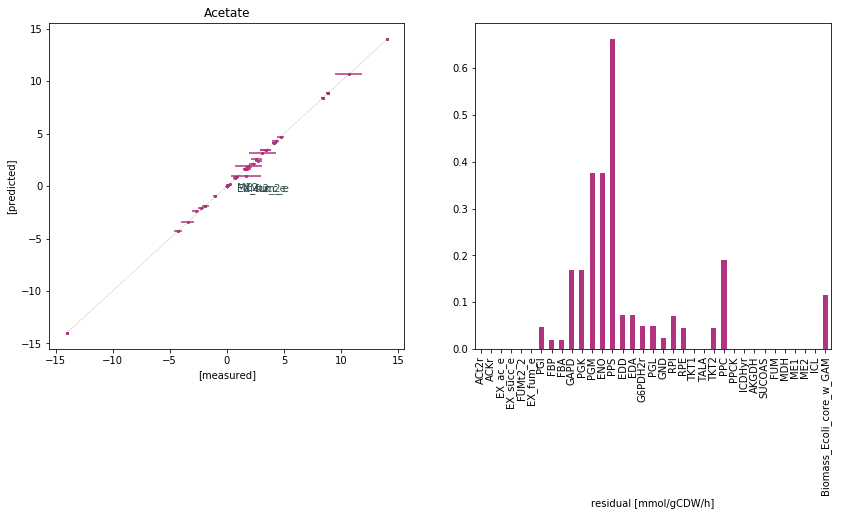

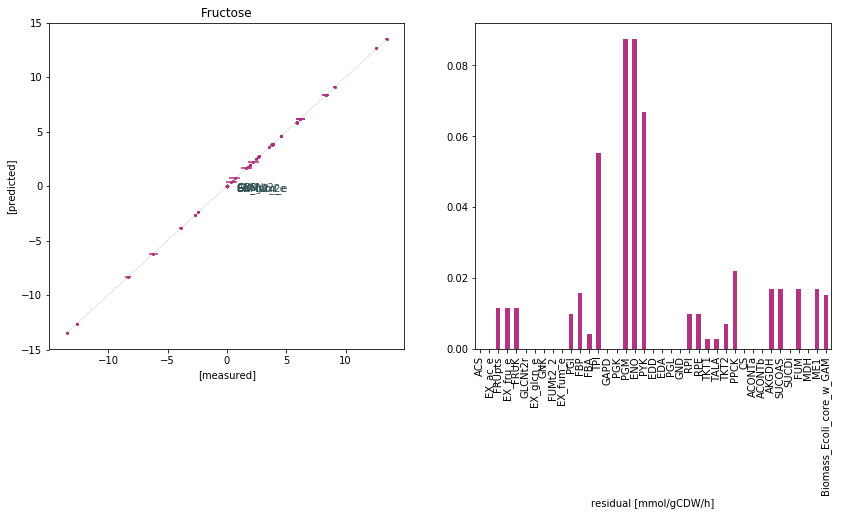

In [564]:
def project_fluxes(model, condition, rxns_13C):
    
    exchange_2_ID = {'Glucose':'EX_glc__D_e','Pyruvate':'EX_pyr_e','Fructose':'EX_fru_e','Acetate':'EX_ac_e', 
        'Succinate':'EX_succ_e','Glycerol':'EX_glyc_e','Gluconate':'EX_glcn_e','Galactose':'EX_gal_e'}

    ### MOMA: obtain flux solution that minimally deviates from 13C flux measurements 
    prob = model.problem
    v = prob.Variable("moma_old_objective")
    c = prob.Constraint(model.solver.objective.expression - v, lb=0.0, ub=0.0, name="moma_old_objective_constraint")
    to_add = [v, c]
    new_obj = Zero
    
    linear = True
    fluxes_df = pd.DataFrame(index=rxns_13C.index, columns=['measured','sigma','predicted','lb','ub'])
    gen = [r for r in model.reactions if r.id in rxns_13C.index]# and r.id != 'Biomass_Ecoli_core_w_GAM'] 
    
    for r in gen:    
        flux = rxns_13C.loc[r.id,condition]
        
        if r.id in [exchange_2_ID[condition]]:
            model.reactions.get_by_id(exchange_2_ID[condition]).lower_bound = flux
        elif r.id.startswith('EX_'):
            if condition == 'Succinate' and r.id == 'EX_fum_e':
                model.reactions.get_by_id('EX_fum_e').lower_bound = flux 
            else:
                flux = abs(flux) ## secretion. (need to check lac in pyr condition, fum in succ condition)
        
        fluxes_df.loc[r.id,'measured'] = flux
        fluxes_df.loc[r.id,'sigma'] = rxns_13C.loc[r.id,condition+'_sd']
        
        if linear:
            model.solver = 'glpk'
            components = sutil.add_absolute_expression(model, r.flux_expression, name="moma_dist_" + r.id, difference=flux, add=False)
            to_add.extend(components)
            new_obj += components.variable
        else:
            model.solver = 'cplex' # not working properly
            dist = prob.Variable("moma_dist_" + r.id)
            const = prob.Constraint(r.flux_expression - dist, lb=flux, ub=flux, name="moma_constraint_" + r.id)
            to_add.extend([dist, const])
            new_obj += dist**2
            
    model.add_cons_vars(to_add)
    model.objective = prob.Objective(new_obj, direction='min')

    solution = model.optimize().fluxes
    solution.to_json(settings.CACHE_DIR+'/FBA_'+condition+'.json')
    
    ### make scatter plot of predicted VS measured
    for r in gen:
        fluxes_df.loc[r.id,'predicted'] = solution.loc[r.id]
        fluxes_df.loc[r.id,'lb'] = model.reactions.get_by_id(r.id).lower_bound
        fluxes_df.loc[r.id,'ub'] = model.reactions.get_by_id(r.id).upper_bound
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    axs[0].plot([fluxes_df['measured'].min(), fluxes_df['measured'].max()], [fluxes_df['predicted'].min(), fluxes_df['predicted'].max()], 'k--', alpha=0.3, linewidth=0.5)
    plot = fluxes_df.plot(kind='scatter', x=['measured'], y=['predicted'], xerr=fluxes_df.loc[:,'sigma'], 
          title = condition, ax=axs[0], linewidth=0, s=10, color=(0.7,0.2,0.5))
    
    ### annotate reactions
    for r in gen:
        xy = fluxes_df.loc[r.id, ['measured', 'predicted']]
        sign = np.sign(xy['measured']) == np.sign(xy['predicted'])
        if not sign:
#             print(condition, r, xy)
            axs[0].annotate(r.id, xy, xytext=(10,-5), textcoords='offset points',
                        family='sans-serif', fontsize=10, color='darkslategrey')
    
    ### histogram of residuals
    fluxes_df['diff'] = fluxes_df[['measured']].sub(fluxes_df['predicted'], axis=0)
#     fluxes_df['diff'] = fluxes_df[['measured']].divide(fluxes_df['predicted'], axis=0)
    residual = fluxes_df.loc[:, 'diff']
    abs(residual[residual!=0]).plot(kind='bar', ax=axs[1], color=(0.7,0.2,0.5))
    axs[1].set_xlabel('residual [mmol/gCDW/h]')        
    fig.savefig(settings.CACHE_DIR+'/MOMA_'+condition+'.pdf')
    
    return solution.to_frame(), fluxes_df

## project fluxes on the gerosa model
conditions= ['Glucose','Gluconate','Galactose','Pyruvate','Glycerol','Succinate','Acetate','Fructose']
flux_solution = dict()
for condition in conditions:
    ebc = BiomassComposition('e_coli')
    growth_rate = float(physiology.loc['growth_rate',condition])
    uncertainty = float(physiology.loc['growth_rate',condition+'_sd'])
    new_biomass = ebc.GetComposition(growth_rate, uncertainty)
    model = adjust_biomass(core.copy(), new_biomass)
    flux_solution[condition], fluxes_df = project_fluxes(model, condition, rxns_13C)

    

IN FLUXES     OUT FLUXES       OBJECTIVES
------------  ---------------  ------------
o2_e  14.8    h2o_e    18.6
ac_e  14      co2_e    15.4
h_e   10.7    acald_e   1.78
pi_e   0.653  for_e     1.11
              akg_e     0.164
